In [236]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

pd.set_option('display.max_columns', 500)
sns.set(font_scale=2)

In [59]:
from pathlib import Path
csvs = Path('data/csv').glob('*.csv')

# Read each CSV file into DataFrame
# This creates a list of dataframes
dfs = []
for filename in csvs:
    dfs.append(pd.read_csv(filename))

In [177]:
# Add some per-df calculated columns
def determined_by_plus(row):
    return row['has_plus?'] and row['score'][:-1] == row['_prev_score']

def calc_additional_columns(df):
    df = df.sort_values(by=['rank'])
    df['_raw_rank'] = df.index + 1
    df['event_id'] = f"{df.loc[0,'season']}_{df.loc[0,'loc']}_{df.loc[0,'category']}_{df.loc[0,'round']}"
    df['_prev_score'] = df['score'].shift(-1)
    df['has_plus?'] = df['score'].apply(lambda x: x.endswith('+'))
    df['determined_by_plus?'] = df.apply(lambda row: determined_by_plus(row), axis=1)
    return df
    
dfs = [calc_additional_columns(df) for df in dfs]

In [163]:
# Research in determining the size of finals and whether rank 8 is always the cutoff
finals = pd.concat([df for df in dfs if df.loc[0, 'round'] == 'final'])
finals_counts = finals.groupby(finals['event_id']).fullname.count().reset_index(name='count') 
#finals_counts.sort_values(['count'], ascending=False)[counts['count'] > 8]
finals_counts = finals_counts.rename(columns={'event_id': '_finals_event_id', 'count': '_finals_athlete_count'}).set_index('_finals_event_id')

In [178]:
# Concatenate all DataFrames
alldf = pd.concat(dfs)
alldf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5649 entries, 0 to 25
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fullname             5649 non-null   object 
 1   season               5649 non-null   int64  
 2   loc                  5649 non-null   object 
 3   discipline           5649 non-null   object 
 4   category             5649 non-null   object 
 5   round                5649 non-null   object 
 6   athlete_id           5649 non-null   int64  
 7   name                 5649 non-null   object 
 8   firstname            5649 non-null   object 
 9   lastname             5649 non-null   object 
 10  country              5649 non-null   object 
 11  federation_id        5649 non-null   int64  
 12  bib                  5506 non-null   float64
 13  rank                 5644 non-null   float64
 14  score                5649 non-null   object 
 15  _prev_score          5318 non-null   object 


In [179]:
# Join finals counts to the dataframe
def finals_event_id(event_id):
    return "_".join(event_id.split('_')[:-1] + ['final'])
    
alldf['_finals_event_id'] = alldf['event_id'].apply(lambda event_id: finals_event_id(event_id))#(lambda event_id: finals_counts.loc[finals_counts['event_id'] == finals_event_id(event_id)]['count'])
alldf = alldf.join(finals_counts, on='_finals_event_id')
# alldf.sample(10)

,fullname,season,loc,discipline,category,round,athlete_id,name,firstname,lastname,country,federation_id,bib,rank,score,_prev_score,has_plus?,determined_by_plus?,event_id,_raw_rank,route_1_start_order,ascents,active,under_appeal,_finals_event_id,_finals_athlete_count
9,IFSC Climbing Worldcup (L) - Kranj (SLO) 2016,2016,KranjWC,lead,men,semi-final,463,Joannes Thomas,Thomas,JOANNES,FRA,10,74.0,10.0,38+,38+,True,False,2016_KranjWC_men_semi-final,10,NaN,NaN,NaN,NaN,2016_KranjWC_men_final,8.0
23,IFSC Climbing Worldcup (L) - Briançon (FRA) 2017,2017,BriançonWC,lead,women,semi-final,3060,Hafsaas Tina Johnsen,Tina Johnsen,HAFSAAS,NOR,39,53.0,24.0,19,15+,False,False,2017_BriançonWC_women_semi-final,24,NaN,NaN,NaN,NaN,2017_BriançonWC_women_final,8.0
16,IFSC - Climbing World Cup (L) - Chamonix (FRA)...,2021,Chamonix,lead,women,semi-final,642,Thompson-Smith Molly,Molly,THOMPSON-SMITH,GBR,11,11.0,17.0,47+,43,True,False,2021_Chamonix_women_semi-final,17,14.0,"[{'route_id': 5195, 'route_name': '1', 'top': ...",False,False,2021_Chamonix_women_final,8.0
24,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,65,Zazulin Evgenii,Evgenii,ZAZULIN,RUS,7,43.0,23.0,32+,32+,True,False,2012_WCH Paris_men_semi-final,25,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0
20,IFSC Climbing Worldcup (L) - Briançon (FRA) 2015,2015,Briançon,lead,women,semi-final,848,Lavarda Jenny,Jenny,LAVARDA,ITA,13,4.0,21.0,35+,34,True,False,2015_Briançon_women_semi-final,21,NaN,NaN,NaN,NaN,2015_Briançon_women_final,8.0
13,IFSC Climbing Worldcup (L) - Puurs (BEL) 2013,2013,Puurs,lead,men,semi-final,864,Vettorata Francesco,Francesco,VETTORATA,ITA,13,75.0,14.0,35+,32+,True,False,2013_Puurs_men_semi-final,14,NaN,NaN,NaN,NaN,2013_Puurs_men_final,9.0
0,"IFSC Climbing Worldcup (L, S) - Arco (ITA) 2016",2016,ArcoWC,lead,men,semi-final,437,Desgranges Romain,Romain,DESGRANGES,FRA,10,83.0,1.0,Top,46+,False,False,2016_ArcoWC_men_semi-final,1,NaN,NaN,NaN,NaN,2016_ArcoWC_men_final,8.0
3,IFSC Climbing Worldcup (L) - Imst (AUT) 2013,2013,Imst,lead,men,semi-final,437,Desgranges Romain,Romain,DESGRANGES,FRA,10,83.0,4.0,48+,46+,True,False,2013_Imst_men_semi-final,4,NaN,NaN,NaN,NaN,2013_Imst_men_final,8.0
0,"IFSC Climbing Worldcup (L,S) - Chamonix (FRA) ...",2012,Chamonix,lead,men,semi-final,1559,McColl Sean,Sean,MCCOLL,CAN,19,124.0,1.0,Top,40+,False,False,2012_Chamonix_men_semi-final,1,NaN,NaN,NaN,NaN,2012_Chamonix_men_final,8.0
24,"IFSC Climbing Worldcup (L,S) - Wujiang (CHN) 2017",2017,Wujiang,lead,women,semi-final,1224,Röck Magdalena,Magdalena,RÖCK,AUT,16,47.0,25.0,18+,13+,True,False,2017_Wujiang_women_semi-final,25,NaN,NaN,NaN,NaN,2017_Wujiang_women_final,8.0


In [184]:
# Calculate column identifying the final spot in finals for every semis
alldf['finals_cutoff_spot?'] = alldf.apply(lambda row: row['_raw_rank'] == row['_finals_athlete_count'] if row['round'] == 'semi-final' else None, axis=1)
#alldf[alldf['event_id'] == '2012_WCH Paris_men_semi-final']

,fullname,season,loc,discipline,category,round,athlete_id,name,firstname,lastname,country,federation_id,bib,rank,score,_prev_score,has_plus?,determined_by_plus?,event_id,_raw_rank,route_1_start_order,ascents,active,under_appeal,_finals_event_id,_finals_athlete_count,finals_cutoff_spot?
0,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,773,Julian Puigblanque Ramón,Ramón,JULIAN PUIGBLANQUE,ESP,12,94.0,1.0,Top,55+,False,False,2012_WCH Paris_men_semi-final,1,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
1,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,1214,Schubert Jakob,Jakob,SCHUBERT,AUT,16,92.0,2.0,55+,54+,True,False,2012_WCH Paris_men_semi-final,2,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
2,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,1559,McColl Sean,Sean,MCCOLL,CAN,19,45.0,3.0,54+,52+,True,False,2012_WCH Paris_men_semi-final,3,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
3,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,1364,Ondra Adam,Adam,ONDRA,CZE,17,32.0,4.0,52+,49+,True,False,2012_WCH Paris_men_semi-final,4,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
4,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,3577,Verhoeven Jorg,Jorg,VERHOEVEN,NED,50,6.0,5.0,49+,49+,True,False,2012_WCH Paris_men_semi-final,5,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
5,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,437,Desgranges Romain,Romain,DESGRANGES,FRA,10,59.0,5.0,49+,49+,True,False,2012_WCH Paris_men_semi-final,6,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
6,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,2254,Amma Sachi,Sachi,AMMA,JPN,25,91.0,5.0,49+,49+,True,False,2012_WCH Paris_men_semi-final,7,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
7,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,2039,Min Hyunbin,Hyunbin,MIN,KOR,21,1.0,5.0,49+,46+,True,False,2012_WCH Paris_men_semi-final,8,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,True
8,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,3058,Midtboe Magnus,Magnus,MIDTBOE,NOR,39,37.0,9.0,46+,44+,True,False,2012_WCH Paris_men_semi-final,9,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
9,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,447,Romain Manuel,Manuel,ROMAIN,FRA,10,4.0,10.0,44+,44+,True,False,2012_WCH Paris_men_semi-final,10,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False


## Analysis

### What percentage of all scores have a plus?

In [192]:
val_counts = alldf['has_plus?'].value_counts()
((val_counts[True] / len(alldf)) * 100).round(2)

69.73

### What percentage of all ranks are determined by a plus?

In [195]:
val_counts = alldf['determined_by_plus?'].value_counts()
((val_counts[True] / len(alldf)) * 100).round(2)

8.44

### What percentage of finals cutoffs are determined by a plus?

In [207]:
filtered_df = alldf.query("`finals_cutoff_spot?` == True")
val_counts = filtered_df['determined_by_plus?'].value_counts()
((val_counts[True] / len(filtered_df)) * 100).round(2)

9.82

### What percentage of podium spots are determined by plus?

In [216]:
filtered_df = alldf.query("`round` == 'final' and `_raw_rank` <= 3")
#filtered_df.head()
val_counts = filtered_df['determined_by_plus?'].value_counts()
#val_counts
((val_counts[True] / len(filtered_df)) * 100).round(2)

4.88

### What % of ranks are decided by plus by gender

Text(0.5, 0.98, 'p determined by plus by gender')

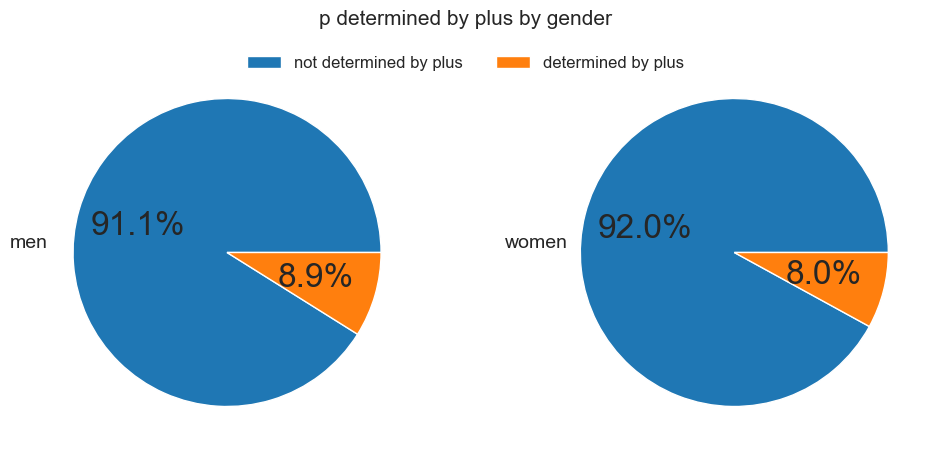

In [257]:
# reshaping the dataframe
ct = pd.crosstab(alldf['determined_by_plus?'], alldf.category)

# display(ct)

# plot and add labels
colors = ['tab:blue', 'tab:orange']  # specify the colors so they can be used in the legend
labels = ["not determined by plus", "determined by plus"]  # used for the legend
axes = ct.plot(kind='pie', autopct='%.1f%%', subplots=True, figsize=(12, 5),
               legend=False, labels=['',''], colors=colors)

# flatten the array of axes
axes = axes.flat

# extract the figure object
fig = axes[0].get_figure()

# rotate the pclass label
for ax in axes:
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, rotation=0, fontsize=14)
    
# create the legend
legend_elements = [Patch(fc=c, label=l) for c, l in zip(colors, labels)]
fig.legend(handles=legend_elements, loc=9, fontsize=12, ncol=2, borderaxespad=0, bbox_to_anchor=(0., 0.8, 1, .102), frameon=False)

fig.suptitle('p determined by plus by gender', fontsize=15)

### How decisive is a plus by year?

In [258]:
# reshaping the dataframe
ct = pd.crosstab(alldf['determined_by_plus?'], alldf.season, normalize='columns').style.format("{:.1%}")

display(ct)

# plot and add labels
# colors = ['tab:blue', 'tab:orange']  # specify the colors so they can be used in the legend
# labels = ["not determined by plus", "determined by plus"]  # used for the legend
# axes = ct.plot(kind='pie', autopct='%.1f%%', subplots=True, figsize=(12, 5),
#                legend=False, labels=['',''], colors=colors)

# # flatten the array of axes
# axes = axes.flat

# # extract the figure object
# fig = axes[0].get_figure()

# # rotate the pclass label
# for ax in axes:
#     yl = ax.get_ylabel()
#     ax.set_ylabel(yl, rotation=0, fontsize=14)
    
# # create the legend
# legend_elements = [Patch(fc=c, label=l) for c, l in zip(colors, labels)]
# fig.legend(handles=legend_elements, loc=9, fontsize=12, ncol=2, borderaxespad=0, bbox_to_anchor=(0., 0.8, 1, .102), frameon=False)

# fig.suptitle('p determined by plus', fontsize=15)

season,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
determined_by_plus?,,,,,,,,,,,,
False,92.4%,93.1%,91.2%,91.3%,89.8%,92.6%,90.7%,92.5%,91.3%,91.7%,90.6%,90.8%
True,7.6%,6.9%,8.8%,8.7%,10.2%,7.4%,9.3%,7.5%,8.7%,8.3%,9.4%,9.2%


In [259]:
ct = pd.crosstab(alldf['determined_by_plus?'], alldf.event_id, normalize='columns').style.format("{:.1%}")

display(ct)

event_id,2012_Atlanta_men_final,2012_Atlanta_men_semi-final,2012_Atlanta_women_final,2012_Atlanta_women_semi-final,2012_Briançon_men_final,2012_Briançon_men_semi-final,2012_Briançon_women_final,2012_Briançon_women_semi-final,2012_Chamonix_men_final,2012_Chamonix_men_semi-final,2012_Chamonix_women_final,2012_Chamonix_women_semi-final,2012_Imst_men_final,2012_Imst_men_semi-final,2012_Imst_women_final,2012_Imst_women_semi-final,2012_Inzai_men_final,2012_Inzai_men_semi-final,2012_Inzai_women_final,2012_Inzai_women_semi-final,2012_Kranj_men_final,2012_Kranj_men_semi-final,2012_Kranj_women_final,2012_Kranj_women_semi-final,2012_Mokpo_men_final,2012_Mokpo_men_semi-final,2012_Mokpo_women_final,2012_Mokpo_women_semi-final,2012_Puurs_men_final,2012_Puurs_men_semi-final,2012_Puurs_women_final,2012_Puurs_women_semi-final,2012_WCH Paris_men_final,2012_WCH Paris_men_semi-final,2012_WCH Paris_women_final,2012_WCH Paris_women_semi-final,2012_Xining_men_final,2012_Xining_men_semi-final,2012_Xining_women_final,2012_Xining_women_semi-final,2013_Briançon_men_final,2013_Briançon_men_semi-final,2013_Briançon_women_final,2013_Briançon_women_semi-final,2013_Imst_men_final,2013_Imst_men_semi-final,2013_Imst_women_final,2013_Imst_women_semi-final,2013_Kranj_men_final,2013_Kranj_men_semi-final,2013_Kranj_women_final,2013_Kranj_women_semi-final,2013_Mokpo_men_final,2013_Mokpo_men_semi-final,2013_Mokpo_women_final,2013_Mokpo_women_semi-final,2013_Perm_men_final,2013_Perm_men_semi-final,2013_Perm_women_final,2013_Perm_women_semi-final,2013_Puurs_men_final,2013_Puurs_men_semi-final,2013_Puurs_women_final,2013_Puurs_women_semi-final,2013_Valence_men_final,2013_Valence_men_semi-final,2013_Valence_women_final,2013_Valence_women_semi-final,2013_Wujiang_men_final,2013_Wujiang_men_semi-final,2013_Wujiang_women_final,2013_Wujiang_women_semi-final,2014_Briançon_men_semi-final,2014_Briançon_women_semi-final,2014_Chamonix_men_final,2014_Chamonix_men_semi-final,2014_Chamonix_women_final,2014_Chamonix_women_semi-final,2014_Gijon_men_final,2014_Gijon_men_semi-final,2014_Gijon_women_final,2014_Gijon_women_semi-final,2014_Haiyang_men_final,2014_Haiyang_men_semi-final,2014_Haiyang_women_final,2014_Haiyang_women_semi-final,2014_Imst_men_final,2014_Imst_men_semi-final,2014_Imst_women_final,2014_Imst_women_semi-final,2014_Inzai_men_final,2014_Inzai_men_semi-final,2014_Inzai_women_final,2014_Inzai_women_semi-final,2014_Kranj_men_final,2014_Kranj_men_semi-final,2014_Kranj_women_final,2014_Kranj_women_semi-final,2014_Mokpo_men_final,2014_Mokpo_men_semi-final,2014_Mokpo_women_final,2014_Mokpo_women_semi-final,2014_Wujiang_men_final,2014_Wujiang_men_semi-final,2014_Wujiang_women_final,2014_Wujiang_women_semi-final,2015_Briançon_men_final,2015_Briançon_men_semi-final,2015_Briançon_women_final,2015_Briançon_women_semi-final,2015_Chamonix_men_final,2015_Chamonix_men_semi-final,2015_Chamonix_women_final,2015_Chamonix_women_semi-final,2015_Imst_men_final,2015_Imst_men_semi-final,2015_Imst_women_final,2015_Imst_women_semi-final,2015_Kranj_men_final,2015_Kranj_men_semi-final,2015_Kranj_women_final,2015_Kranj_women_semi-final,2015_Puurs_men_final,2015_Puurs_men_semi-final,2015_Puurs_women_final,2015_Puurs_women_semi-final,2015_Stavanger_men_final,2015_Stavanger_men_semi-final,2015_Stavanger_women_final,2015_Stavanger_women_semi-final,2015_Wujiang_men_final,2015_Wujiang_men_semi-final,2015_Wujiang_women_final,2015_Wujiang_women_semi-final,2016_ArcoWC_men_final,2016_ArcoWC_men_semi-final,2016_ArcoWC_women_final,2016_ArcoWC_women_semi-final,2016_BriançonWC_men_final,2016_BriançonWC_men_semi-final,2016_BriançonWC_women_final,2016_BriançonWC_women_semi-final,2016_ChamonixWC_men_final,2016_ChamonixWC_men_semi-final,2016_ChamonixWC_women_final,2016_ChamonixWC_women_semi-final,2016_ImstWC_men_final,2016_ImstWC_men_semi-final,2016_ImstWC_women_final,2016_ImstWC_women_semi-final,2016_KranjWC_men_final,2016_KranjWC_men_semi-final,2016_KranjWC_women_final,2016_KranjWC_women_semi-final,2016_VillarsWC_

In [266]:
# how important is the plus in finals vs semi finals?
ct = pd.crosstab(alldf['determined_by_plus?'], alldf['round'], normalize='columns').style.format("{:.1%}")

display(ct)

round,final,semi-final
determined_by_plus?,,
False,95.7%,90.3%
True,4.3%,9.7%


In [223]:
# Save df to csv
alldf.to_csv('data/alldf.csv', encoding='utf8')

In [260]:
alldf[alldf['event_id'] == '2012_WCH Paris_men_semi-final']

,fullname,season,loc,discipline,category,round,athlete_id,name,firstname,lastname,country,federation_id,bib,rank,score,_prev_score,has_plus?,determined_by_plus?,event_id,_raw_rank,route_1_start_order,ascents,active,under_appeal,_finals_event_id,_finals_athlete_count,finals_cutoff_spot?
0,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,773,Julian Puigblanque Ramón,Ramón,JULIAN PUIGBLANQUE,ESP,12,94.0,1.0,Top,55+,False,False,2012_WCH Paris_men_semi-final,1,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
1,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,1214,Schubert Jakob,Jakob,SCHUBERT,AUT,16,92.0,2.0,55+,54+,True,False,2012_WCH Paris_men_semi-final,2,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
2,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,1559,McColl Sean,Sean,MCCOLL,CAN,19,45.0,3.0,54+,52+,True,False,2012_WCH Paris_men_semi-final,3,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
3,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,1364,Ondra Adam,Adam,ONDRA,CZE,17,32.0,4.0,52+,49+,True,False,2012_WCH Paris_men_semi-final,4,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
4,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,3577,Verhoeven Jorg,Jorg,VERHOEVEN,NED,50,6.0,5.0,49+,49+,True,False,2012_WCH Paris_men_semi-final,5,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
5,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,437,Desgranges Romain,Romain,DESGRANGES,FRA,10,59.0,5.0,49+,49+,True,False,2012_WCH Paris_men_semi-final,6,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
6,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,2254,Amma Sachi,Sachi,AMMA,JPN,25,91.0,5.0,49+,49+,True,False,2012_WCH Paris_men_semi-final,7,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
7,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,2039,Min Hyunbin,Hyunbin,MIN,KOR,21,1.0,5.0,49+,46+,True,False,2012_WCH Paris_men_semi-final,8,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,True
8,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,3058,Midtboe Magnus,Magnus,MIDTBOE,NOR,39,37.0,9.0,46+,44+,True,False,2012_WCH Paris_men_semi-final,9,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
9,IFSC Climbing World Championship - Paris (FRA)...,2012,WCH Paris,lead,men,semi-final,447,Romain Manuel,Manuel,ROMAIN,FRA,10,4.0,10.0,44+,44+,True,False,2012_WCH Paris_men_semi-final,10,NaN,NaN,NaN,NaN,2012_WCH Paris_men_final,8.0,False
